In [5]:
# Import necessary libraries
import pickle # For loading/saving model files
import numpy as np # For numerical operations
import pandas as pd # For data manipulation and analysis
import matplotlib.pyplot as plt # For plotting data
from sklearn.model_selection import learning_curve # For generating learning curves
from sklearn.metrics import mean_squared_error, r2_score # For evaluation metrics (MSE, R², etc.)
from scipy.stats import linregress # For linear regression analysis
from tqdm import tqdm # For progress bar visualization
from sklearn.exceptions import InconsistentVersionWarning # For handling version warnings
from sklearn.dummy import DummyRegressor
import warnings
# Suppress InconsistentVersionWarning for sklearn compatibility
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
# Suppress UserWarning for missing feature names in predictions
warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names")
# Suppress FutureWarning for LGBMRegressor's sklearn tags
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils._tags")
# Suppress FutureWarning for 'force_all_finite' deprecation
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite'.*")

In [6]:
# Path to the standardized database directory
base_path = '../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv")
df_test = pd.read_csv(f"{base_path}/test.csv")

feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity', 
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train = df_train[feature_names].values
y_train = df_train['PL'].values
X_test = df_test[feature_names].values
y_test = df_test['PL'].values

print(f"\nTraining samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print('\nDataset loaded successfully!\n')

# Load models from Models folder
with open('Models/rf_final_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
with open('Models/lgbm_final_model.pkl', 'rb') as f:
    lgb_model = pickle.load(f)
with open('Models/xgb_final_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

models = {'RF': rf_model, 'LGBM': lgb_model, 'XGB': xgb_model}
figsize = (15, 5)  # Wider for 1x3 subplots
save_path = '../../Comprehensive ML - Files & Plots etc/'


Training samples: 1663627, Test samples: 415907

Dataset loaded successfully!



/home/nahshon/envs/ml001/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [09:52:56] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [7]:
# Compute learning curves for each model
lc_data = {}
for name, model in tqdm(models.items(), desc="Computing Learning Curves"):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), 
        scoring='neg_root_mean_squared_error'
    )
    lc_data[name] = {
        'train_sizes': train_sizes,
        'train_rmse': -train_scores.mean(axis=1),
        'test_rmse': -test_scores.mean(axis=1)
    }

# Compute predictions and residuals for each model
res_data = {}
pred_data = {}  # Also for predicted vs real
phys_data = {}
dist = df_test['distance'].values
log_dist = np.log10(dist + 1e-6)  # For physics

for name, model in tqdm(models.items(), desc="Computing Predictions & Residuals"):
    y_test_pred = model.predict(X_test)
    residuals = y_test - y_test_pred
    slope, intercept, r_value, _, _ = linregress(log_dist, y_test_pred)
    
    res_data[name] = {
        'y_test_pred': y_test_pred,
        'residuals': residuals
    }
    pred_data[name] = y_test_pred
    phys_data[name] = {
        'y_test_pred': y_test_pred,
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value
    }

Computing Predictions & Residuals: 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]


In [8]:
# Compute RMSE and R2 for each model on test data
results_data = []
for name, y_test_pred in pred_data.items():
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    results_data.append({
        'Model': name,
        'RMSE': test_rmse,
        'R2': test_r2
    })

# Create and display table
results = pd.DataFrame(results_data)
results = results.sort_values(by='RMSE')
print("\nModel Performance Table:")
display(results)


Model Performance Table:


,Model,RMSE,R2
1,LGBM,4.810903,0.934663
2,XGB,4.830702,0.934124
0,RF,4.991120,0.929676


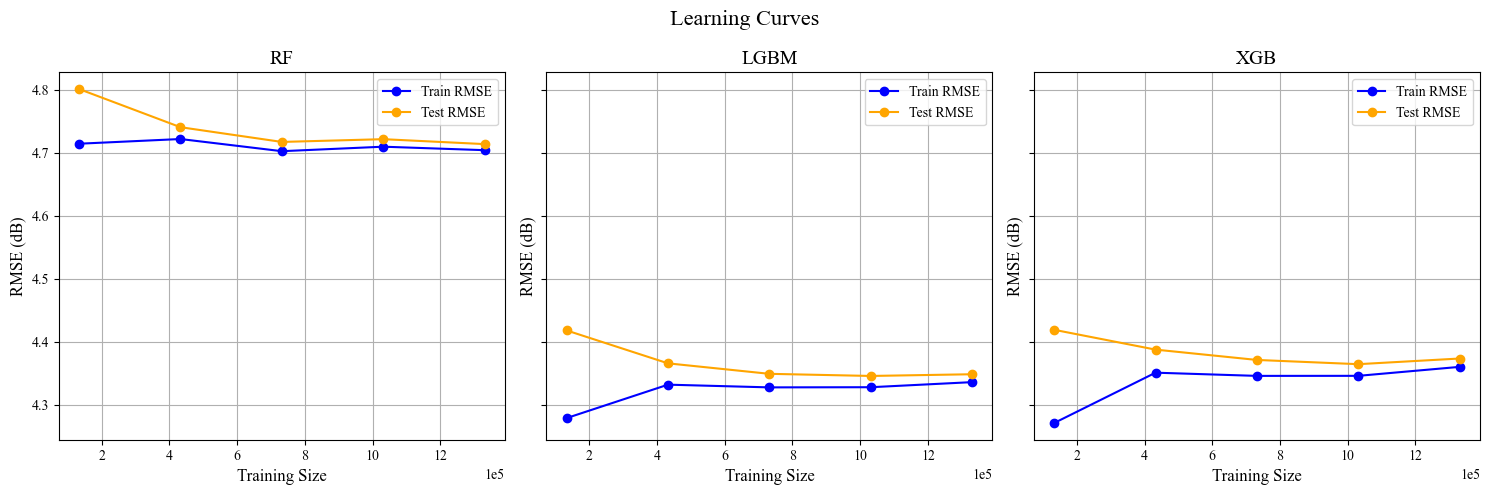

In [9]:
# Plot learning curves in 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
fig.suptitle('Learning Curves', fontsize=16)

for i, (name, data) in enumerate(lc_data.items()):
    ax = axes[i]
    ax.plot(data['train_sizes'], data['train_rmse'], 'o-', color='blue', label='Train RMSE')
    ax.plot(data['train_sizes'], data['test_rmse'], 'o-', color='orange', label='Test RMSE')
    ax.set_xlabel('Training Size', fontsize=12)
    ax.set_ylabel('RMSE (dB)', fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=10)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(5,5))  # X-axis in 10^5 scale

plt.tight_layout()
#plt.savefig(f'{save_path}learning_curves_combined.png', dpi=300)
plt.show()

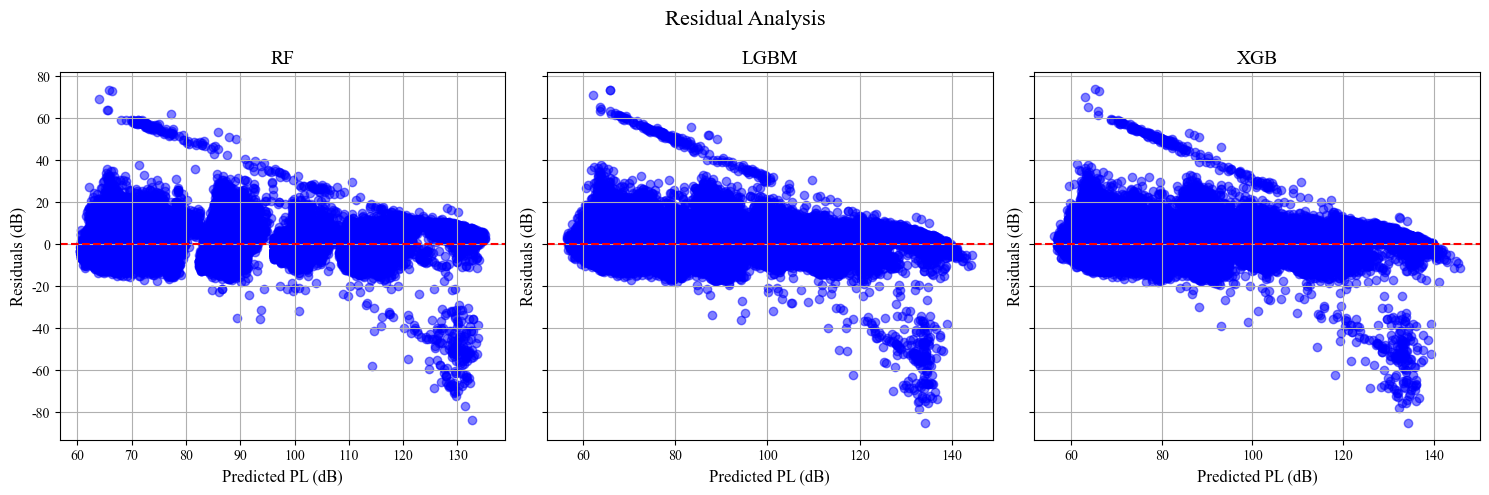

In [10]:
# Plot residuals in 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
fig.suptitle('Residual Analysis', fontsize=16)

for i, (name, data) in enumerate(res_data.items()):
    ax = axes[i]
    ax.scatter(data['y_test_pred'], data['residuals'], alpha=0.5, color='blue')
    ax.axhline(0, color='r', linestyle='--', linewidth=1.5)
    ax.set_xlabel('Predicted PL (dB)', fontsize=12)
    ax.set_ylabel('Residuals (dB)', fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
#plt.savefig(f'{save_path}residuals_combined.png', dpi=300)
plt.show()

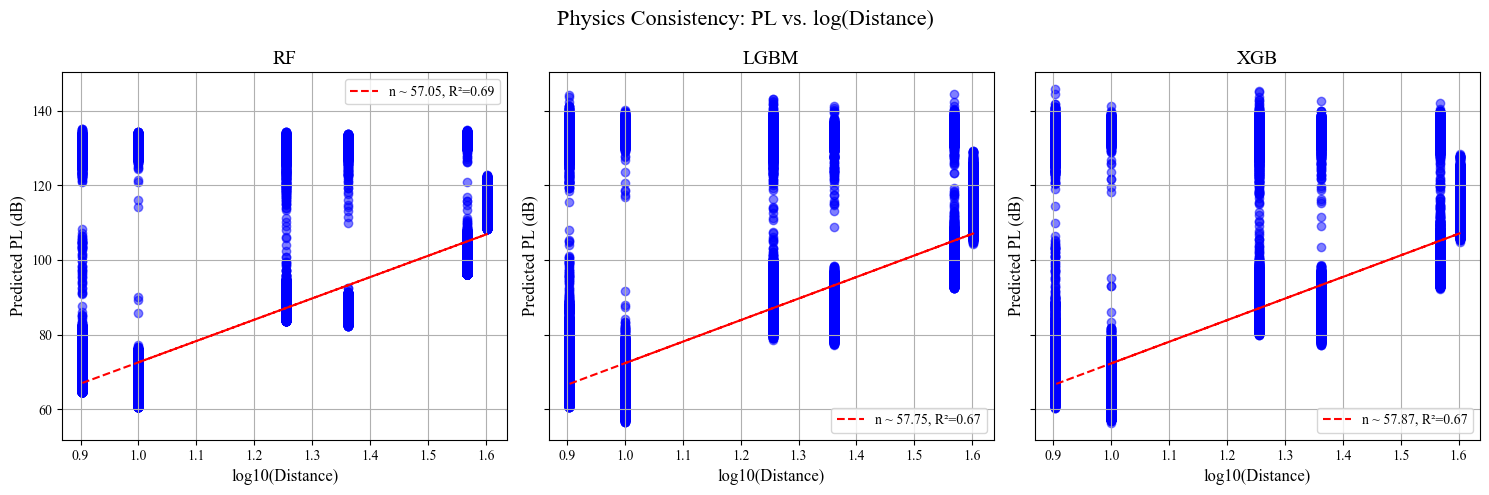

In [11]:
# Plot PL vs. log(Distance) in 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
fig.suptitle('Physics Consistency: PL vs. log(Distance)', fontsize=16)

for i, (name, data) in enumerate(phys_data.items()):
    ax = axes[i]
    ax.scatter(log_dist, data['y_test_pred'], alpha=0.5, color='blue')
    ax.plot(log_dist, data['intercept'] + data['slope'] * log_dist, 'r--', 
            label=f'n ~ {data["slope"]:.2f}, R²={data["r_value"]**2:.2f}', linewidth=1.5)
    ax.set_xlabel('log10(Distance)', fontsize=12)
    ax.set_ylabel('Predicted PL (dB)', fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
#plt.savefig(f'{save_path}physics_consistency_combined.png', dpi=300)
plt.show()

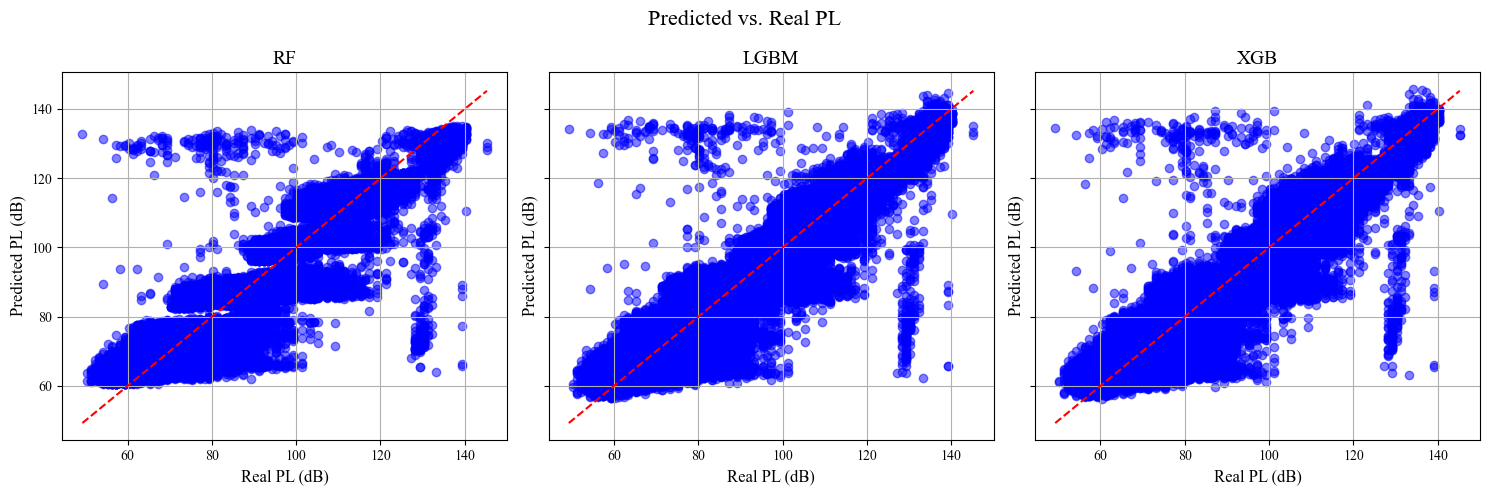

In [12]:
# Plot Predicted vs. Real PL in 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
fig.suptitle('Predicted vs. Real PL', fontsize=16)

min_pl = y_test.min()
max_pl = y_test.max()

for i, (name, y_test_pred) in enumerate(pred_data.items()):
    ax = axes[i]
    ax.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
    ax.plot([min_pl, max_pl], [min_pl, max_pl], 'r--', linewidth=1.5)
    ax.set_xlabel('Real PL (dB)', fontsize=12)
    ax.set_ylabel('Predicted PL (dB)', fontsize=12)
    ax.set_title(name, fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
#plt.savefig(f'{save_path}pred_vs_real_combined.png', dpi=300)
plt.show()